In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import pyccl as ccl

from tqdm import tqdm #for timing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from IPython.display import HTML
from IPython.display import display

import sys
sys.path.insert(1, '../src/')
from lib import *
import params as pm

In this notebook, we generate all the relevant plots.

Relevant plots are:
- Correlation matrix plots as a function of models (difference with model A)
- $\left(\frac{C^{\rm obs}_{L}}{C^{\rm th}_{L}} - 1 \right)$ vs. $L$ error plots as a function of models
- $\left(\frac{C^{\rm obs}_{L}}{C^{\rm A}_{L}} - 1 \right)$ vs. $L$ error plots as a function of models
- ${\rm SN}_{\ell_{\rm lmax}}$ vs $\ell$ plots as a function of models **ERRORBAR?**

Load saved $\tilde{C}^{\rm obs}_{\ell}$ and bin values

In [3]:
exp_names = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
experiments = {}

#dict to store values
for name in exp_names:
    experiments[name] = {}

#load cls from memory

for key in experiments:
    experiments[key]['cls_obs'] = np.load("../dat/pCls/1000mocks/pCls_" + key + ".npy")
    experiments[key]['CLs_obs'] = np.zeros((pm.NMOCKS, pm.ELL.shape[0] - 1))
    experiments[key]['pCLs_obs'] = np.zeros((pm.NMOCKS, pm.ELL.shape[0] - 1))
    
   #read in fsky and nl
    experiments[key]['nl'] = np.load("../dat/pCls/1000mocks/noise_window_" +key +".npy")
    experiments[key]['fsky'] = np.load("../dat/pCls/1000mocks/fsky_" +key +".npy")
    
#calculate pCls
for key in ['A', 'B', 'C']:
    #experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] * experiments[key]['fsky'][:,np.newaxis]) + \
    #experiments[key]['nl'][:,np.newaxis]
    experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] * experiments[key]['fsky'][:,np.newaxis])
    
for key in ['D', 'E', 'F']:
    #experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] + experiments[key]['nl'][:,np.newaxis]) * \
    # experiments[key]['fsky'][:,np.newaxis]
    experiments[key]['pcls_obs'] = (experiments[key]['cls_obs']) * experiments[key]['fsky'][:,np.newaxis]
    
#bin power spectrum
for key in experiments:
    for i in range(pm.NMOCKS):
        ELL_mid, experiments[key]['CLs_obs'][i] = bin_mat(pm.ell[:pm.NSIDE], 
                                                           experiments[key]['cls_obs'][i][:pm.NSIDE],
                                                           pm.ELL) #Cls up to NSIDE is good 
        ELL_mid, experiments[key]['pCLs_obs'][i] = bin_mat(pm.ell[:pm.NSIDE], 
                                                           experiments[key]['pcls_obs'][i][:pm.NSIDE],
                                                           pm.ELL) #Cls up to NSIDE is good 

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [4]:
#calculate cov matrix and cumulative SN
for key in experiments: 
    experiments[key]['covmat'] = np.cov(experiments[key]['pCLs_obs'].T)
    experiments[key]['corrcoeff'] = np.corrcoef(experiments[key]['pCLs_obs'].T)
    experiments[key]['SN_cum'] = SN_cum(experiments[key]['covmat'], ELL_mid, 
                                       experiments[key]['pCLs_obs'].mean(axis = 0), lmax = pm.LMAX,
                                       use_hartlap=True, nsim = pm.NMOCKS)

In [5]:
#set colours for models
experiments['A']['colour'] = 'black'
experiments['B']['colour'] = 'red'
experiments['C']['colour'] = 'green'
experiments['D']['colour'] = 'blue'
experiments['E']['colour'] = 'purple'
experiments['F']['colour'] = 'magenta'

Look at the condition number

In [6]:
for key in experiments:
    print(np.linalg.cond(experiments[key]['covmat']))

1104157.837013224
1092797.5676721109
144293892.28350234
1099944.8178082965
534302.9992684785
280517140.725178


Load saved $\tilde{C}^{\rm th}_{\ell}$ and bin values

In [8]:
pcl_th_A = np.load("../dat/pCls/th/pcl_th_Favg.npy") #for model A
pcl_th_BC = np.load("../dat/pCls/th/pcl_th.npy") #for models B and C
cls_elg_th = np.load("/home/tkarim/imaging-sys-covariance/dat/cosmology_ini/gaussian_mocks/cl_th.npy")

## Covariance matrices

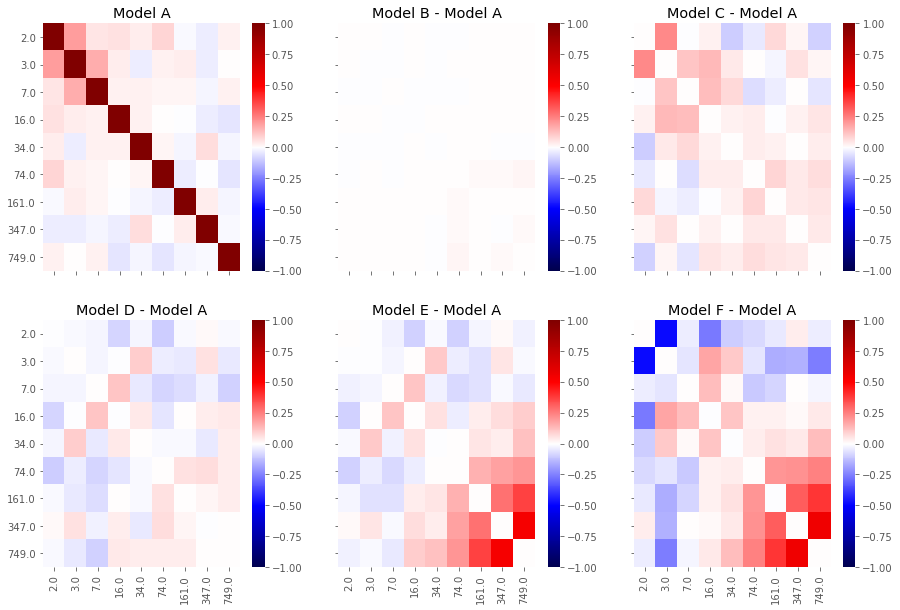

In [10]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (15, 10))

ticklabels = np.round(ELL_mid)

sns.heatmap(experiments['A']['corrcoeff'], ax = axs[0,0], cmap = 'seismic', xticklabels=ticklabels, 
           yticklabels=ticklabels, vmin = -1, vmax = +1)
axs[0, 0].set_title('Model A')

i = 0
j = 1
for key in ['B', 'C', 'D', 'E', 'F']:
    sns.heatmap(experiments[key]['corrcoeff'] - experiments['A']['corrcoeff'], 
                ax = axs[i,j], cmap = 'seismic', xticklabels=ticklabels, 
           yticklabels=ticklabels, vmin = -1, vmax = +1)
    axs[i, j].set_title('Model ' + key + ' - Model A')
    
    j += 1
    if(j == 3):
        i = 1
        j = 0

## SNR comparison

<ipython-input-11-6268f7ed954d>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(ELL_mid, experiments[key]['SN_cum']/experiments['A']['SN_cum'], label = key,
<ipython-input-11-6268f7ed954d>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(ELL_mid, experiments[key]['SN_cum']/experiments['A']['SN_cum'], label = key,
<ipython-input-11-6268f7ed954d>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(ELL_mid, experiments[key]['SN_cum']/experiments['A']['SN_cum'], label = key,
<ipython-input-11-6268f7ed954d>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(ELL_mid, experiments[key]['SN_cum']/experiments['A']['SN_cum'], label = key,
<ipython-input-11-6268f7ed954d>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(ELL_mid, experiments[key]['SN_cum']/experiments['A']['SN_cum'], label = key,
<ipython-input-11-6268f7ed954d>:8: RuntimeWarning: invalid value encountered in true_divid

Text(0, 0.5, 'SN$(\\ell_{\\rm max})$ (Normalized to Model A)')

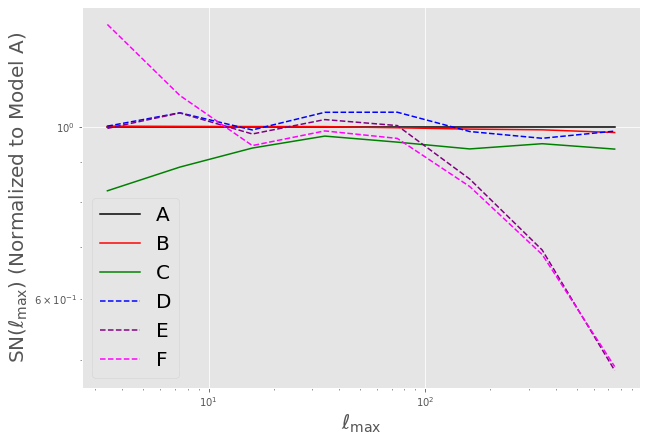

In [11]:
plt.figure(figsize = pm.fsize)
for key in experiments: 
    if((key == 'D') | (key == 'E') | (key == 'F')):
        ls = '--'
    else:
        ls = '-'
        
    plt.loglog(ELL_mid, experiments[key]['SN_cum']/experiments['A']['SN_cum'], label = key,
                c = experiments[key]['colour'], ls = ls)
    
plt.legend(loc = 'best', fontsize = pm.fs)
plt.xlabel(r"$\ell_{\rm max}$", fontsize = pm.fs)
plt.ylabel(r"SN$(\ell_{\rm max})$ (Normalized to Model A)", fontsize = pm.fs)
#plt.ylim([.5, 1.5])

### Compare theory $\tilde{C_{\ell}}$ with expected $\tilde{C_{\ell}}$

#### Compare theory Cl with theory pCl after fsky correction for best case scenario benchmark

No handles with labels found to put in legend.


(-0.25, 1.25)

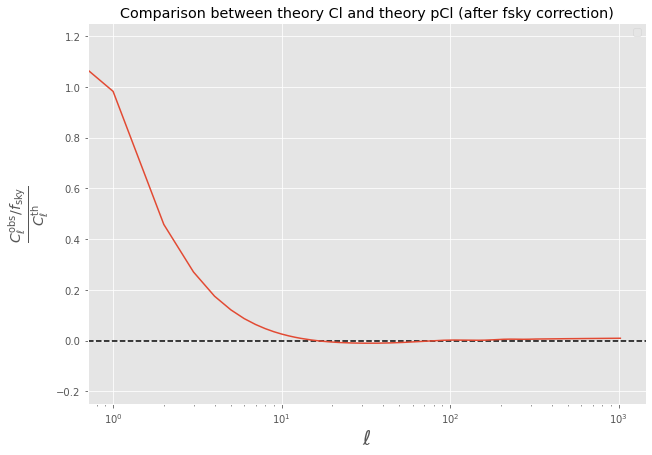

In [5]:
plt.figure(figsize = pm.fsize)
plt.axhline(0, c = 'k', ls = '--')
plt.semilogx(pm.ell[:pm.NSIDE], (pcl_th_A/experiments['A']['fsky'][0])[:pm.NSIDE]/cls_elg_th[:pm.NSIDE] - 1)
plt.legend(loc = 'best')
plt.xlabel(r"$\ell$", fontsize = pm.fs)
plt.ylabel(r"$\frac{C^{\rm obs}_{\ell}/f_{\rm sky}}{C^{\rm th}_{\ell}}$", fontsize = pm.fs)
plt.title("Comparison between theory Cl and theory pCl (after fsky correction)")
plt.ylim([-0.25, 1.25])

In [16]:
(experiments['F']['cls_obs'])[:pm.NSIDE].mean(axis = 0)/cls_obs_A_mean

array([443.64813177,  47.36689222,  36.19384763, ...,   0.92964874,
         0.91980629,   0.90915859])

In [17]:
(experiments['B']['cls_obs'])[:pm.NSIDE].mean(axis = 0)/cls_obs_A_mean

array([0.9979589 , 1.00296131, 1.00062688, ..., 1.00039401, 1.00058187,
       1.00063292])

Text(0.5, 0, '$L$')

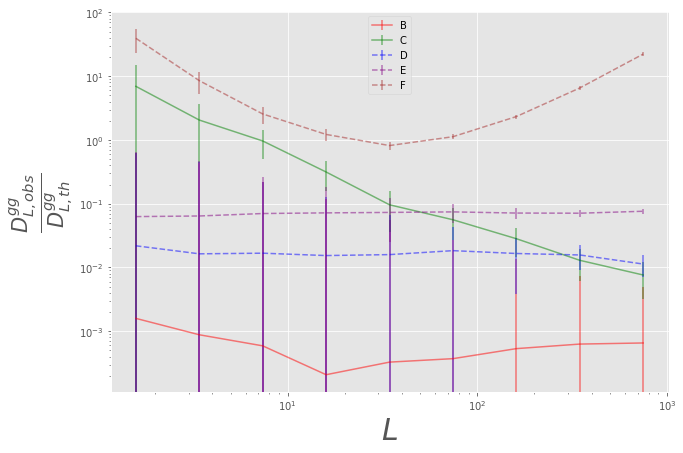

In [40]:
plt.figure(figsize=pm.fsize)
for key in ['B', 'C', 'D', 'E', 'F']:
    if((key == 'D') | (key == 'E') | (key == 'F')):
        ls = '--'
    else:
        ls = '-'
        
    plt.errorbar(ELL_mid, 
                 np.abs((experiments[key]['pCLs_obs'].mean(axis = 0)/experiments['A']['pCLs_obs'].mean(axis = 0)) - 1), 
                 label = key, c = experiments[key]['colour'], ls = ls,
                yerr = (np.sqrt(np.diag(experiments[key]['covmat']))/experiments['A']['pCLs_obs'].mean(axis = 0)),
                alpha = 0.5)

plt.xscale('log')
plt.yscale('log')
#plt.axhline(1, c = 'blue', label = 'Theory')
plt.legend(loc = 'best')
plt.ylabel(r"$\frac{D^{gg}_{L, obs}}{D^{gg}_{L, th}}$", fontsize = 30)
plt.xlabel(r"$L$", fontsize = 30)

Text(0.5, 0, '$L$')

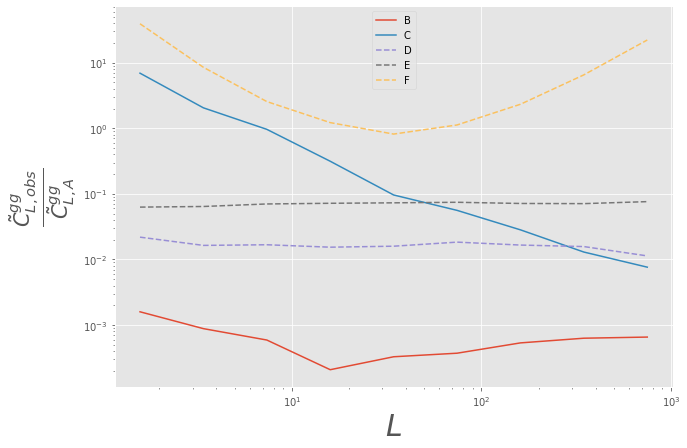

In [10]:
plt.figure(figsize=pm.fsize)
for key in ['B', 'C', 'D', 'E', 'F']:
    if((key == 'D') | (key == 'E') | (key == 'F')):
        ls = '--'
    else:
        ls = '-'
        
    plt.loglog(ELL_mid, 
                 np.abs((experiments[key]['pCLs_obs'].mean(axis = 0)/experiments['A']['pCLs_obs'].mean(axis = 0)) -1), 
                 label = key, ls = ls)

#plt.axhline(1, c = 'blue', label = 'Theory')
plt.legend(loc = 'best')
plt.ylabel(r"$\frac{\tilde{C}^{gg}_{L, obs}}{\tilde{C}^{gg}_{L, A}}$", fontsize = 30)
plt.xlabel(r"$L$", fontsize = 30)

In [56]:
np.sqrt(np.diag(experiments['E']['covmat']))/experiments['A']['CLs_obs'].mean(axis = 0)

array([0.22572096, 0.15754228, 0.07466721, 0.04148825, 0.01847662,
       0.00949543, 0.00515242, 0.00314525, 0.00265372])

Text(0.5, 0, '$L$')

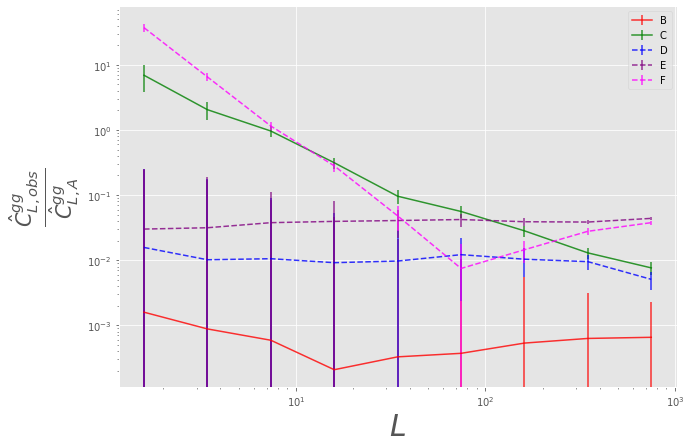

In [12]:
plt.figure(figsize=pm.fsize)
for key in ['B', 'C', 'D', 'E', 'F']:
    if((key == 'D') | (key == 'E') | (key == 'F')):
        ls = '--'
    else:
        ls = '-'
        
    plt.errorbar(ELL_mid, 
                 np.abs((experiments[key]['CLs_obs'].mean(axis = 0)/experiments['A']['CLs_obs'].mean(axis = 0)) -1), 
                 label = key, ls = ls, alpha = 0.8, c = experiments[key]['colour'],
                 yerr = (np.sqrt(np.diag(experiments[key]['covmat']))/experiments['A']['CLs_obs'].mean(axis = 0)))

plt.xscale("log")
plt.yscale("log")
#plt.axhline(1, c = 'blue', label = 'Theory')
plt.legend(loc = 'best')
plt.ylabel(r"$\frac{\hat{C}^{gg}_{L, obs}}{\hat{C}^{gg}_{L, A}}$", fontsize = 30)
plt.xlabel(r"$L$", fontsize = 30)

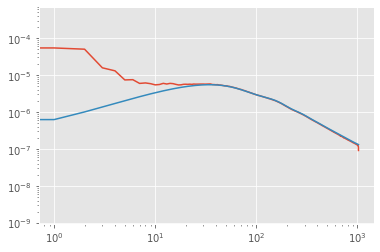

In [9]:
plt.loglog(pm.ell[:pm.NSIDE], (experiments['F']['cls_obs'].mean(axis = 0)), 
                 label = key)
plt.loglog(pm.ell[:pm.NSIDE], 
                 cls_elg_th[:pm.NSIDE], 
                 label = key)

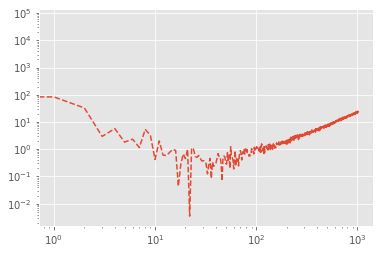

In [59]:
    plt.loglog(pm.ell[:pm.NSIDE], 
                 np.abs((experiments[key]['cls_obs'][0]/cls_elg_th[:1024]) -1), 
                 label = key, ls = ls)

Text(0.5, 0, '$L$')

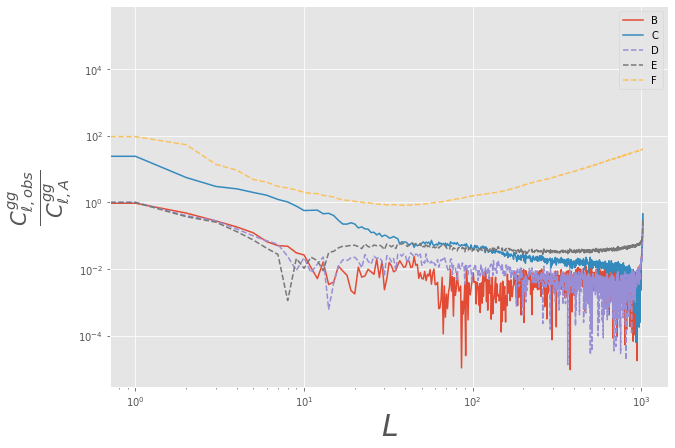

In [58]:
plt.figure(figsize=pm.fsize)
for key in ['B', 'C', 'D', 'E', 'F']:
    if((key == 'D') | (key == 'E') | (key == 'F')):
        ls = '--'
    else:
        ls = '-'
        
    plt.loglog(pm.ell[:pm.NSIDE], 
                 np.abs((experiments[key]['cls_obs'].mean(axis = 0)/cls_elg_th[:1024]) -1), 
                 label = key, ls = ls)

#plt.axhline(1, c = 'blue', label = 'Theory')
plt.legend(loc = 'best')
plt.ylabel(r"$\frac{C^{gg}_{\ell, obs}}{C^{gg}_{\ell, A}}$", fontsize = 30)
plt.xlabel(r"$L$", fontsize = 30)